# HPA Usage
Pesquisa por código no Github, buscando por arquivos que contenham definições de HPA (HorizontalPodAutoscaler).

Filtra por repositórios com alguma relevância (número de estrelas) e apresenta estatísticas.

Os arquivos encontrados após o filtro são salvos no diretório `search_results`.

## Preparando o ambiente

In [129]:
import os
import time
import re
import json
import requests
import yaml
from dotenv import dotenv_values
from ghapi.core import GhApi, HTTP422UnprocessableEntityError
import numpy as np
import pandas as pd
from matplotlib import  pyplot as plt

In [2]:
config = {
  **os.environ,
  **dotenv_values(".env")
}
github = GhApi(token=config['GITHUB_TOKEN'])

In [3]:
github.rate_limit.get()['resources']['core']

```json
{'limit': 5000, 'remaining': 5000, 'reset': 1732450661, 'used': 0}
```

## Definindo Funções Principais

In [86]:
def get_repo_stars(item):
  name_parts = re.split(r'/', item['repo_name'])
  repo_details = github.repos.get(owner=name_parts[0], repo=name_parts[1])
  return repo_details['stargazers_count']


def extract_hpa(yaml_content):
  hpa_list = []
  for doc in yaml_content:
    if isinstance(doc, dict) and doc.get('kind') == "HorizontalPodAutoscaler":
      hpa_list.append(doc)
  return hpa_list


def download_hpa_spec(item):
  if not os.path.isdir('search_results'):
    os.mkdir('search_results')

  print(f"Downloading {item['url']}")
  response = requests.get(item['url'])
  if response.status_code == 200:

    # Remove marcações de template Helm
    clean_text = re.sub(r'{{-.*?}}', '', response.text)
    clean_text = re.sub(r'{{.*?}}', 'helm_command', clean_text)

    yaml_content = list(yaml.safe_load_all(clean_text))
    hpa_content = extract_hpa(yaml_content)
    if hpa_content is None:
      return

    target_path = os.path.join("search_results", item['repo_name'], item['file_path'])
    target_dir = os.path.dirname(target_path)
    os.makedirs(target_dir, exist_ok=True)
    
    with open(target_path, 'w') as file:
      file.write(yaml.dump_all(hpa_content))
  else:
    print(f"Loading {url} returned {response.status_code}")


def download_file(item):
  if not os.path.isdir('search_results'):
    os.mkdir('search_results')

  print(f"Downloading {item['url']}")
  response = requests.get(item['url'])
  if response.status_code == 200:
    target_path = os.path.join("search_results", item['repo_name'], item['file_path'])
    target_dir = os.path.dirname(target_path)
    os.makedirs(target_dir, exist_ok=True)
      
    with open(target_path, 'w') as file:
      file.write(response.text)
  else:
    print(f"Loading {url} returned {response.status_code}")
    

# Realiza a Busca

In [122]:
result_items = []
page = 1

# Carrega a primeira página de itens da pesquisa
search_result = github.search.code(q='"kind: HorizontalPodAutoscaler" language:yaml', per_page=100, page=page)
result_items.extend(search_result['items'])

# Carrega as demais páginas da pesquisa
print(f"Encontrados {search_result['total_count']} itens")
while len(result_items) < search_result['total_count']:
  rate_remaining = github.rate_limit.get()['resources']['code_search']['remaining']
  if rate_remaining <= 1 or search_result['incomplete_results']:
    print(f"Aguardando code_search.remaining {rate_remaining}")
    time.sleep(1)
    continue
  result_items.extend(search_result['items'])
  page += 1
  print(f"Carregando página {page}")
  try:
    search_result = github.search.code(q='"kind: HorizontalPodAutoscaler" language:yaml', per_page=100, page=page)
  except HTTP422UnprocessableEntityError as e:
    display(e)
    break
  
display(f"Foram carregados {len(result_items)} resultados")

Encontrados 4024 itens
Carregando página 2
Carregando página 3
Carregando página 4
Carregando página 5
Carregando página 6
Carregando página 7
Carregando página 8
Carregando página 9
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando c

<HTTPError 422: 'Unprocessable Entity\n====Error Body====\n{\n  "message": "Cannot access beyond the first 1000 results",\n  "documentation_url": "https://docs.github.com/rest/search/search#search-code",\n  "status": "422"\n}\n'>

'Foram carregados 1100 resultados'

In [105]:
search_items = []
for item in result_items:
  search_items.append({
    'repo_name': item['repository']['full_name'],
    'file_path': item['path'],
    'url': item['html_url'].replace('/blob/', '/raw/')
  })

items = pd.DataFrame(search_items)
display(items)

,repo_name,file_path,url
0,learnk8s/spring-boot-k8s-hpa,kube/hpa.yaml,https://github.com/learnk8s/spring-boot-k8s-hp...
1,krestomatio/keydb-operator,watches.yaml,https://github.com/krestomatio/keydb-operator/...
2,zuisong/vertx-server-push,k8s.yml,https://github.com/zuisong/vertx-server-push/r...
3,huseyinbabal/kubernetes-node-example,k8s/hpa.yml,https://github.com/huseyinbabal/kubernetes-nod...
4,amitshishodia/my-mongo,hpa.yaml,https://github.com/amitshishodia/my-mongo/raw/...
...,...,...,...
1095,steblynskyi/infrastructure,environments/prod/kubernetes/services/ota/book...,https://github.com/steblynskyi/infrastructure/...
1096,GoogleCloudPlatform/ai-on-gke,tutorials-and-examples/genAI-LLM/deploying-mis...,https://github.com/GoogleCloudPlatform/ai-on-g...
1097,rommelsinkam/espresso-shop-project,.vscode-server/data/User/History/71600096/8d5I...,https://github.com/rommelsinkam/espresso-shop-...
1098,projeto-fiap-2023-Q1-64/projeto-fiap-iac-infra,kubernetes/pagamento-deployment.yaml,https://github.com/projeto-fiap-2023-Q1-64/pro...


In [184]:
len(items['repo_name'].unique())

856

## Número de Estrelas

In [106]:
items['repo_stars'] = items.apply(func=get_repo_stars, axis=1)

In [179]:
print(f"min:  {items['repo_stars'].min()}")
print(f"max:  {items['repo_stars'].max()}")
print(f"mean: {items['repo_stars'].mean()}")
display(items['repo_stars'].describe())

filtered_items = items[items['repo_stars'] > 50]
display(filtered_items['repo_stars'].describe())

filter_outliers_items = items[items['repo_stars'] >= items['repo_stars'].quantile(0.90)]
display(filter_outliers_items['repo_stars'].describe())


min:  0
max:  29225
mean: 132.76181818181817


count     1100.000000
mean       132.761818
std       1335.499398
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max      29225.000000
Name: repo_stars, dtype: float64

count       87.000000
mean      1638.505747
std       4505.606941
min         52.000000
25%        106.000000
50%        171.000000
75%        577.000000
max      29225.000000
Name: repo_stars, dtype: float64

count      111.000000
mean      1294.909910
std       4037.715566
min         45.000000
25%         58.000000
50%        121.000000
75%        318.000000
max      29225.000000
Name: repo_stars, dtype: float64

In [185]:
len(filtered_items['repo_name'].unique())

54

Text(0.5, 1.0, 'Histograma Repo Stars > 50')

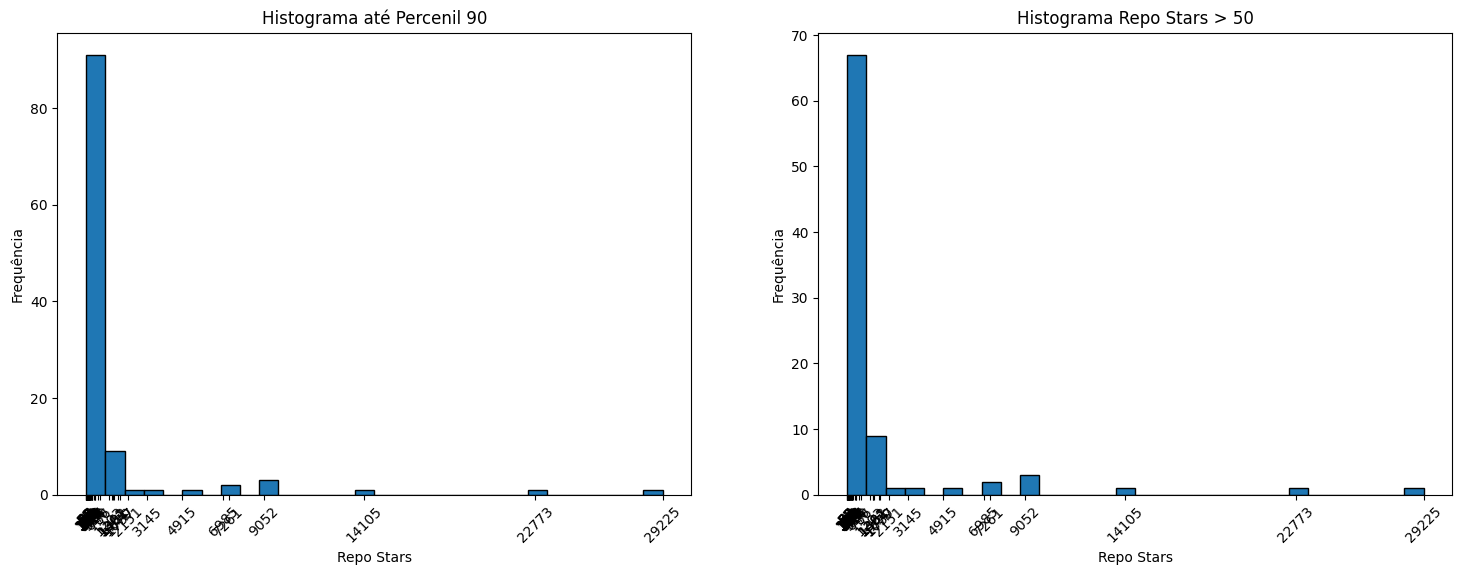

In [181]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
bins=30
# bins = np.concatenate((np.linspace(0, 50, 20), np.linspace(50, filter_outliers_items['repo_stars'].max(), 10)))

axes[0].hist(filter_outliers_items['repo_stars'], bins=bins, edgecolor='black')
axes[0].set_xlabel("Repo Stars")
axes[0].set_ylabel("Frequência")
axes[0].set_title("Histograma até Percenil 90")
axes[0].set_xticks(filter_outliers_items['repo_stars'].unique())
axes[0].tick_params(axis="x", rotation=45)
axes[1].hist(filtered_items['repo_stars'], bins=bins, edgecolor='black')
axes[1].set_xlabel("Repo Stars")
axes[1].set_ylabel("Frequência")
axes[1].set_xticks(filtered_items['repo_stars'].unique())
axes[1].tick_params(axis="x", rotation=45)
axes[1].set_title("Histograma Repo Stars > 50")

In [156]:
filtered_items = filtered_items.sort_values(by=['repo_stars'])
filtered_items

,repo_name,file_path,url,repo_stars
701,intel/workload-services-framework,staging/deathstarbench-hotelreservation/helm_h...,https://github.com/intel/workload-services-fra...,52
1,krestomatio/keydb-operator,watches.yaml,https://github.com/krestomatio/keydb-operator/...,53
101,krestomatio/keydb-operator,watches.yaml,https://github.com/krestomatio/keydb-operator/...,53
513,giantswarm/starboard-exporter,helm/starboard-exporter/templates/customMetric...,https://github.com/giantswarm/starboard-export...,58
608,PostHog/charts-clickhouse,charts/posthog/templates/web-hpa.yaml,https://github.com/PostHog/charts-clickhouse/r...,58
...,...,...,...,...
229,bitnami/charts,bitnami/concourse/templates/worker/horizontalp...,https://github.com/bitnami/charts/raw/f29e7aa4...,9052
759,bitnami/charts,bitnami/spark/templates/hpa-worker.yaml,https://github.com/bitnami/charts/raw/f29e7aa4...,9052
758,openimsdk/open-im-server,deployments/charts/openim-rpc-msg/templates/hp...,https://github.com/openimsdk/open-im-server/ra...,14105
1045,Budibase/budibase,charts/budibase/templates/automation-worker-se...,https://github.com/Budibase/budibase/raw/87112...,22773


In [157]:
filtered_items.apply(download_file, axis=1)

701     None
1       None
101     None
513     None
608     None
        ... 
229     None
759     None
758     None
1045    None
227     None
Length: 87, dtype: object